In [38]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns 

import os  

# Splitting Data
from sklearn.model_selection import train_test_split

## Feature Selection
from sklearn.preprocessing import StandardScaler

## models
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import confusion_matrix, accuracy_score

from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA

In [3]:
File_Path = os.path.join(os.getcwd(), 'heart_disease_uci_encoding.csv')
df = pd.read_csv(File_Path)
df.head()

,age,gender,dataset,chest_pain_type,resting_blood_pressure,fasting_blood_sugar,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,num,age_cholesterol_ratio,bp_cholesterol_ratio,heart_rate_stress,risk_index
0,63,1,0,3,145.0,1,150.0,0,2.3,0,0.269231,0.619658,2.343750,228.0
1,67,1,0,0,160.0,0,108.0,1,1.5,1,0.233449,0.557491,1.588235,338.0
2,67,1,0,0,120.0,0,129.0,1,2.6,1,0.291304,0.521739,1.897059,220.0
3,37,1,0,2,130.0,0,187.0,0,3.5,0,0.147410,0.517928,4.921053,193.0
4,41,0,0,1,130.0,0,172.0,0,1.4,0,0.200000,0.634146,4.095238,162.0


### Splitting Data

In [4]:
X = df.drop(columns = ['num'])
y = df['num']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

In [6]:
print(f'shape of X train --> {X_train.shape}')
print(f'shape of X test --> {X_test.shape}')
print(f'shape of y train --> {y_train.shape}')
print(f'shape of y test --> {y_test.shape}')

shape of X train --> (734, 13)
shape of X test --> (184, 13)
shape of y train --> (734,)
shape of y test --> (184,)


In [22]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Models

### K-Means Clustering

In [26]:
# Elbow method to find optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

In [28]:
inertia

[11934.0,
 9706.138395164082,
 8848.785160463349,
 8269.495542073388,
 7796.951164382226,
 7275.818966874682,
 7056.677956357667,
 6706.357634869479,
 6485.992248202034,
 6247.357226231825]

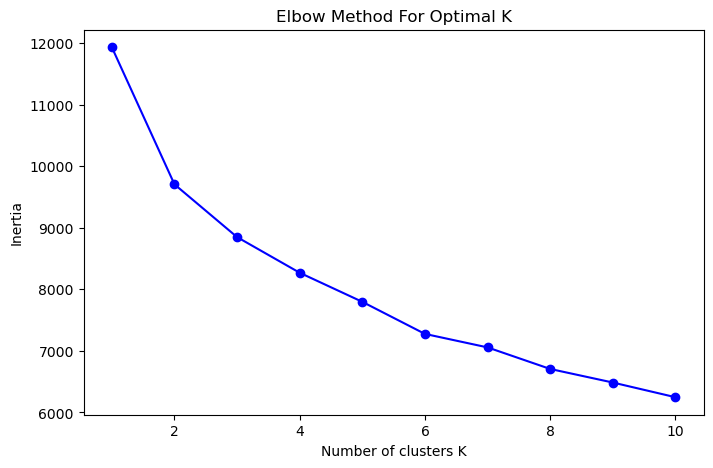

In [30]:
# Plot elbow curve
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', color='blue')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.show()

In [32]:
k_optimal = 2
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

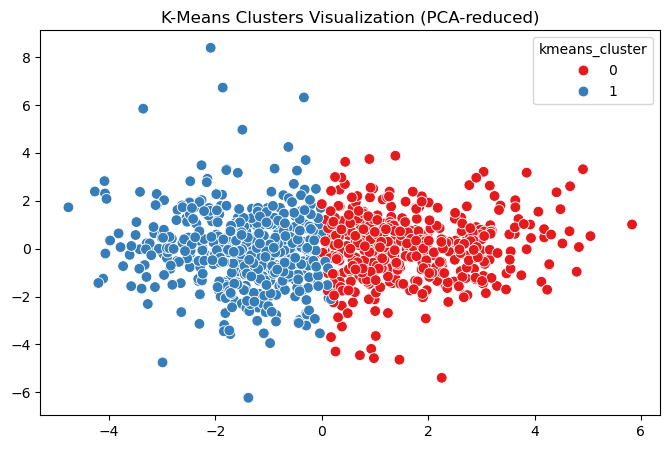

In [36]:
# Visualize clusters (2D using first two principal components for simplicity)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['kmeans_cluster'], palette='Set1', s=60)
plt.title('K-Means Clusters Visualization (PCA-reduced)')
plt.show()

In [40]:
# Reduce to 3 principal components
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_scaled)

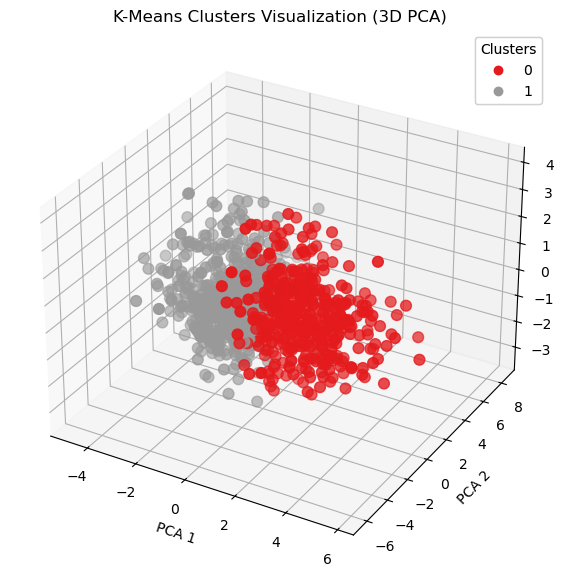

In [44]:
# Plot 3D scatter
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with clusters
scatter = ax.scatter(
    X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2],
    c=df['kmeans_cluster'], cmap='Set1', s=60, depthshade=True
)

# Labels
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.set_title('K-Means Clusters Visualization (3D PCA)')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

### Hierarchical Clustering

In [47]:
# Compute linkage matrix
linked = linkage(X_scaled, method='ward')

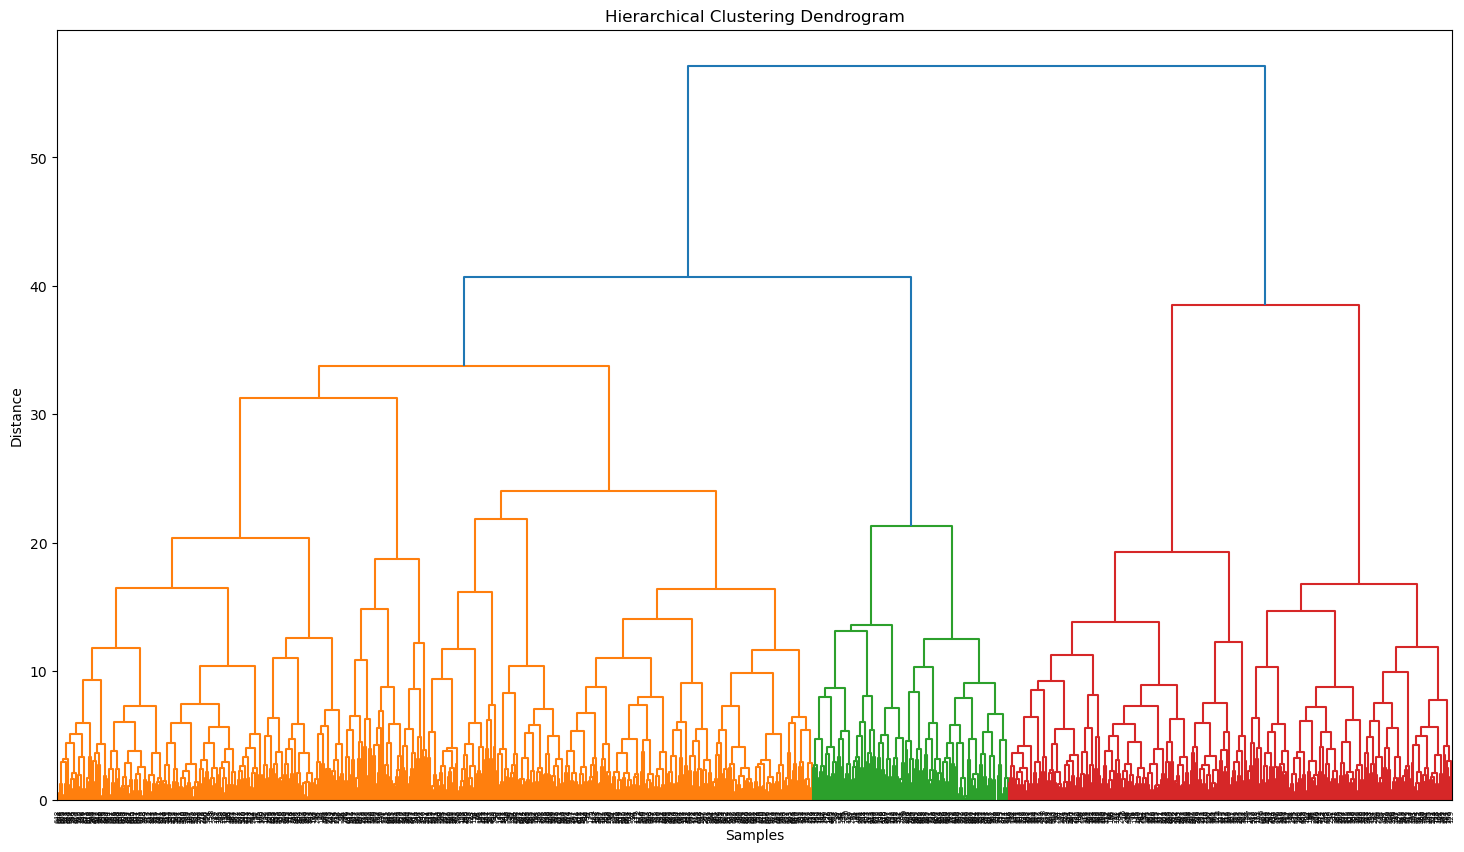

In [51]:
# Plot dendrogram
plt.figure(figsize=(18, 10))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [53]:
# Form clusters (choose 2 clusters as example)
df['hier_cluster'] = fcluster(linked, 2, criterion='maxclust')

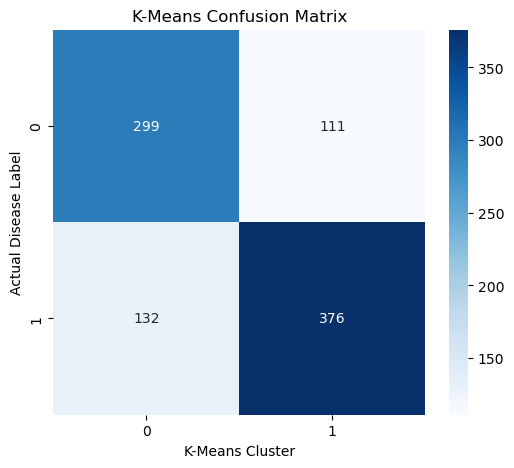

In [57]:
cm = confusion_matrix(df['num'], df['kmeans_cluster'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('K-Means Cluster')
plt.ylabel('Actual Disease Label')
plt.title('K-Means Confusion Matrix')
plt.show()

In [59]:
# Compute confusion matrices
cm_kmeans = confusion_matrix(df['num'], df['kmeans_cluster'])
cm_hier = confusion_matrix(df['num'], df['hier_cluster'])

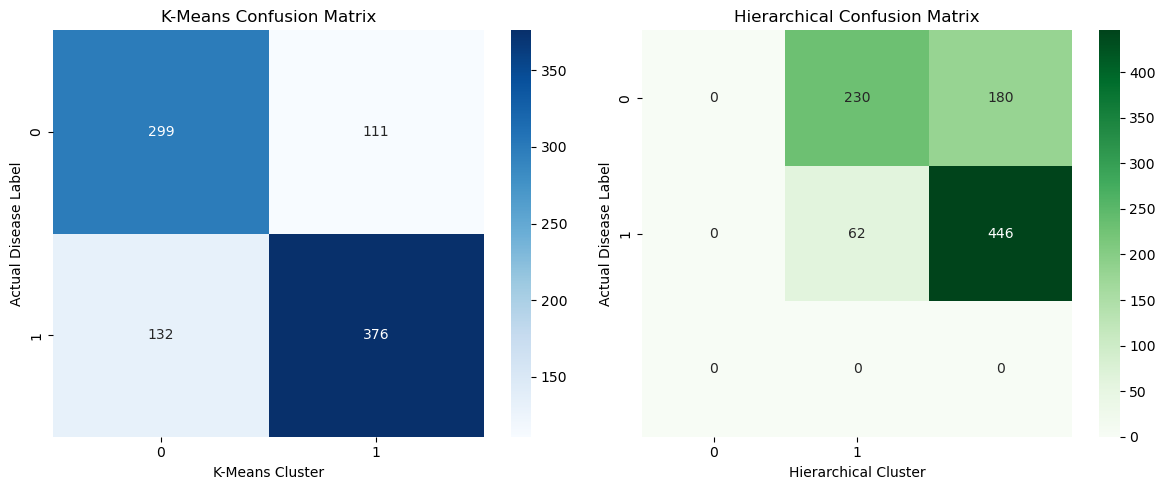

In [63]:
## Plot confusion matrices side by side

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[0,1], yticklabels=[0,1])
axes[0].set_xlabel('K-Means Cluster')
axes[0].set_ylabel('Actual Disease Label')
axes[0].set_title('K-Means Confusion Matrix')

sns.heatmap(cm_hier, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=[0,1], yticklabels=[0,1])
axes[1].set_xlabel('Hierarchical Cluster')
axes[1].set_ylabel('Actual Disease Label')
axes[1].set_title('Hierarchical Confusion Matrix')

plt.tight_layout()
plt.show()

C:\Users\mo\AppData\Local\Temp\ipykernel_3508\2131353428.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='kmeans_cluster', data=df, palette='Blues', ax=axes[0])
C:\Users\mo\AppData\Local\Temp\ipykernel_3508\2131353428.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hier_cluster', data=df, palette='Greens', ax=axes[1])


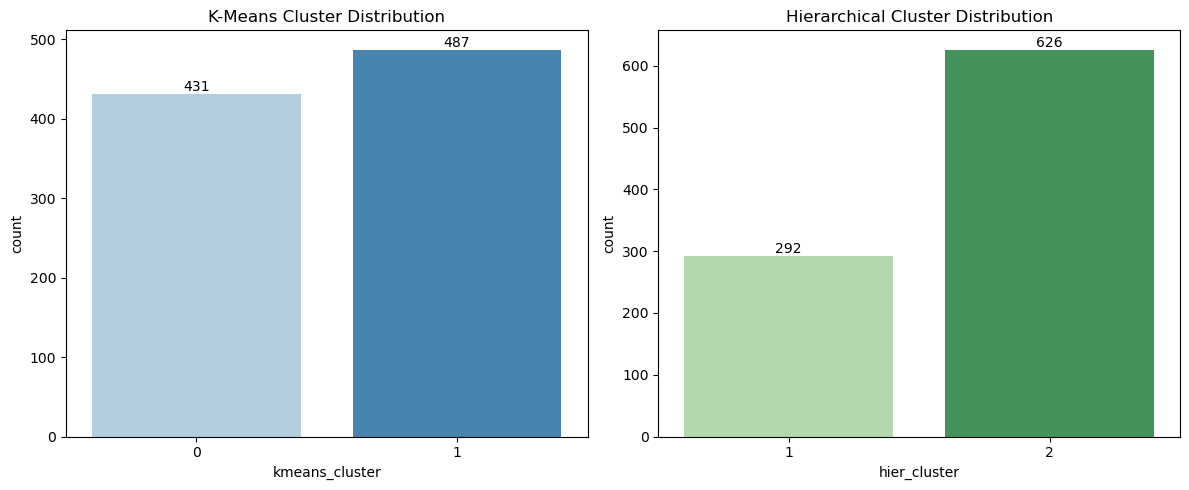

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# K-Means
sns.countplot(x='kmeans_cluster', data=df, palette='Blues', ax=axes[0])
axes[0].set_title('K-Means Cluster Distribution')
# Annotate bars
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',  # cast to int
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom')

# Hierarchical
sns.countplot(x='hier_cluster', data=df, palette='Greens', ax=axes[1])
axes[1].set_title('Hierarchical Cluster Distribution')
# Annotate bars
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}',  # cast to int
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()